In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


Download the data
----------------------

First get the data from (this is a big file!):

https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EW0GgrAdcVxOhVPweTZ5zHIBFJFRTlV6Bc6Bnx5hvQMo1g?e=krhZ6N

The dataset contains the time series spectra for a transit of WASP-39b. You will need the times, wavelengths, and the spectra in order to create transit light curves for specific wavelength channels. This tutorial quickly shows you how to create some light curves.

There are a couple of quirks to the data. First, to see the content you can try:
```$ h5ls spectral_time_series_ERS_TEST_WASP-39.h5```
from the command line (I do not know if this works on windows). Otherwise just ```print(F.keys())``` once you've read in the file as ```F``` with h5py. The various ```S_*``` and ```Se_*``` datasets contain the spectra extracted in slightly different ways. The ```_ap*``` and ```_opt_ap*``` refer to aperture extraction and optimal extraction, respectively (we can discuss the difference later). The number after refers to the aperature width. We will use the optimal extracted data with width 3 pixels to start with. We will also ignore the errors for now, as it's normally better to infer them from the data rather than from Poisson noise estimates.

The other potentially important issue is that the spectra are saturated from pixels 62 to 88 (inclusive). Therefore the data might be a little tricky to work with there. In addition, the data is partially saturated from pixels 27 to 115.

In [2]:
label = "ERS_TEST_WASP-39"
file = 'spectral_time_series_{}.h5'.format(label)

#read in datasets from hdf5 file
# times / wavelength / Spectra (time x wl) / Errors (time x wl)
datasets = "times_bjd wl S_opt_ap3.0".split()
with h5py.File(file,'r') as F:
  t,wl,S = [F[d][()] for d in datasets]

print(wl.size,wl.min(),wl.max())


432 0.5529481393771666 5.370811383030093


Text(0, 0.5, 'time[BJD]')

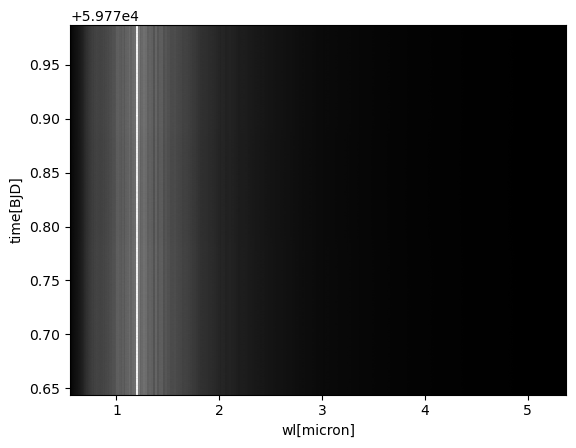

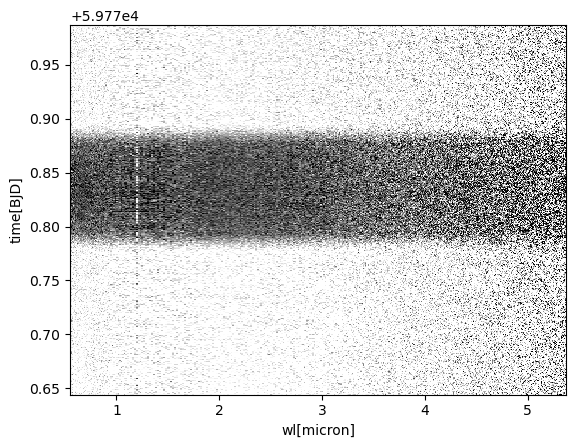

In [3]:
# plot the time-series spectra

plt.figure()
plt.pcolormesh(wl,t,S)
plt.xlabel('wl[micron]')
plt.ylabel('time[BJD]')

#better to normalise the spectra first
plt.figure()
plt.pcolormesh(wl,t,S/np.median(S,axis=0),vmin=0.97,vmax=1.001)
plt.xlabel('wl[micron]')
plt.ylabel('time[BJD]')

# you can already see the transits!! JWST is awesome!!


Ok, so normally we want to sum up the spectra over wl channels to create our light curves. Let's do this for a broadband light curve - let's try from 3-4um.



Text(0.5, 0, 'time[BJD]')

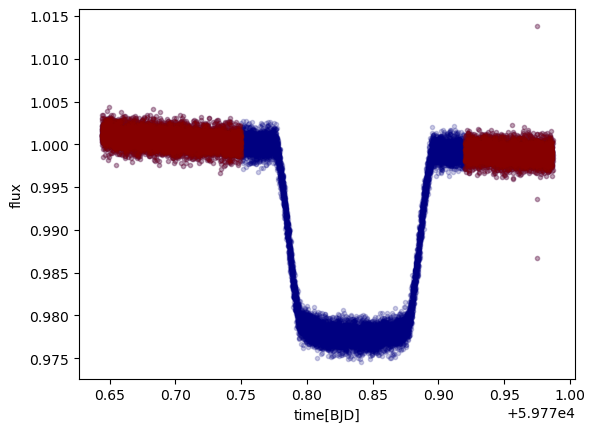

In [4]:

#Let's find where the wl >= 3 and <= 4.
index = (wl >= 3) * (wl <= 4)
#filter the data using the index, then sum over wl
flux = S[:,index].sum(axis=1)
#let's normaluse the transit using out-of-transit data
oot_index = (t < 59770.75) + (t > 59770.92)
flux /= flux[oot_index].mean()

plt.figure()
plt.plot(t,flux,'o',ms=3,alpha=0.2,color='navy')
plt.plot(t[oot_index],flux[oot_index],'o',ms=3,alpha=0.2,color='darkred')
plt.ylabel('flux')
plt.xlabel('time[BJD]')


Below shows a slightly better way of doing this, where pixels that fall partly between wavelength channels are weighted properly. This also allows you to smooth the edges of the extraction windows (we'll ignore for now).

Text(0.5, 0, 'time[BJD]')

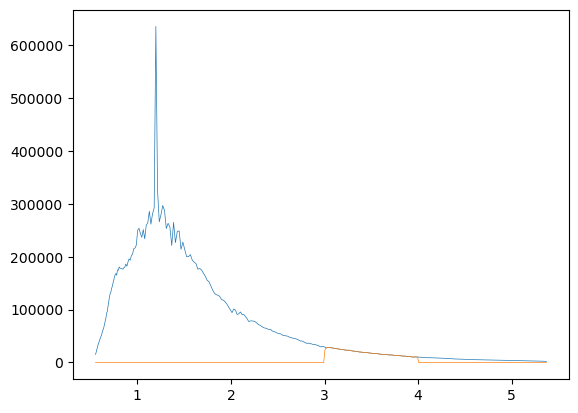

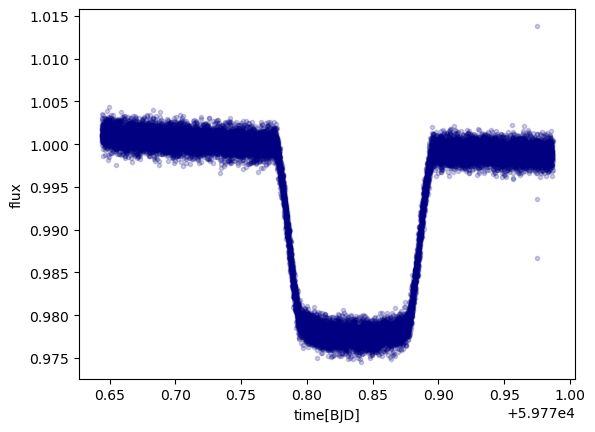

In [5]:
def CosLobe(N):
  """
  Construct cosine lobe function to convolve the extraction window
  N should be an integer
  
  """

  x = np.arange(-N/2.,N/2.+1,1)
  w = np.cos(x/N*np.pi)
  return w/w.sum()

def ExtWindow(x,x0,w,wt=None):
  """
  Return an extraction window over an input grid x
  
  x: input grid (x coords/wavelength)
  x0: centre of window
  w: width of window
  wt: convolution width for tukey window
    None keeps rectangular window, otherwise convolved with cosine lobe for tukey window
  
  """
  
  #first construct rectangular window
  x_grad = np.gradient(x) #scale by gradient to account for non-integer/non-linear steps
  win = np.clip((-np.abs(x0 - x)+w/2.)/x_grad+0.5,0,1)
  win[x_grad<0] = 0. #fixes odd bug if gradient is negative (although needs to be monotonically rising for x_grad anyway)
  
  if wt is not None:
    #first convert the tukey width into x scale
    pix_size = (x[-1]-x[0]) / x.size
    pix_wt = wt / pix_size
    #construct the cosine lobe and convolve with rect window
    c = CosLobe(round(pix_wt))
    win = np.convolve(c,win,mode='same')
  
  return win

#create extraction window
win = ExtWindow(wl,3.5,1)

#plot the spectrum plus window
plt.figure()
mean_spectrum = S.mean(axis=0)
plt.plot(wl,mean_spectrum,'-',lw=0.5)
plt.plot(wl,mean_spectrum*win,'-',lw=0.5)

#sum the flux over the window
flux = (S*win).sum(axis=1)
flux /= flux[oot_index].mean()

#and plot as before
plt.figure()
plt.plot(t,flux,'o',ms=3,alpha=0.2,color='navy')
plt.ylabel('flux')
plt.xlabel('time[BJD]')


We can go one step further, and use these to extract lots of light curves

Text(0.5, 0, 'time[BJD]')

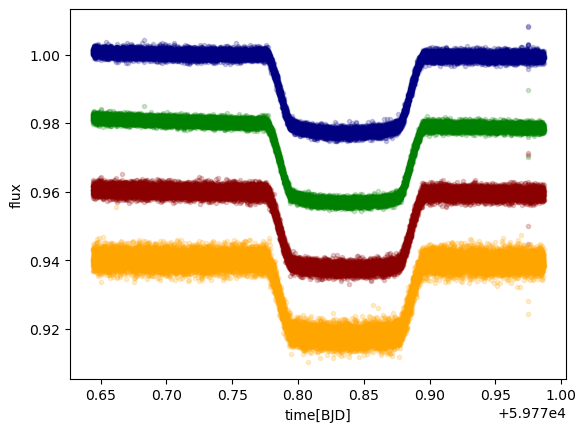

In [6]:

#create windows of width 1 micron centred at 2,3,4,5 micron
wins = [ExtWindow(wl,c,1) for c in (2,3,4,5)]

#extract the flux for each, arrange in array
flux = np.array([(S*w).sum(axis=1) for w in wins])

#normalise (the transposes are just one way to get round broadcasting rules neatly)
flux = (flux.T / flux[:,oot_index].mean(axis=1)).T

#and plot as before
plt.figure()
colors = ['navy','green','darkred','orange']
offset = 0.02
for i,(f,c) in enumerate(zip(flux,colors)):
  plt.plot(t,f-i*offset,'o',ms=3,alpha=0.2,color=c)
plt.ylabel('flux')
plt.xlabel('time[BJD]')
